In [1]:
# from detectron2.data.build import build_detection_test_loader, build_detection_train_loader

from detectron2 import model_zoo
from detectron2.config import get_cfg

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
from models.rpn import ProposalNetwork
import skimage
import torchvision.transforms as T
from models.rpn import get_modelzoo_config
from simclr_lvis import keep

import PIL.Image as im
from torch.utils.data import Dataset
from torchvision import transforms
import os 
from simclr_lvis import prepare_object_pairs
import torchvision

In [18]:
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
import torch.nn as nn

In [ ]:
import cv2
from tqdm.notebook import tqdm

In [ ]:
cmodel_ = torchvision.models.resnet101(pretrained=True)
cmodel = nn.Sequential(*list(cmodel_.children())[:-1])
cmodel.eval()

In [6]:
rpn = ProposalNetwork(device='cuda')
cfg = rpn.cfg

Build Predictor using cfg


In [7]:
cfg.MODEL.WEIGHTS = r'/scratch/users/zzweng/output/coco/classagnostic1/model_0021999.pth'
rpn.predictor = DefaultPredictor(cfg)

In [264]:
data_root = r'/scratch/users/zzweng/datasets'
data_path = os.path.join(data_root, "VOC2012/JPEGImages/")
labels_path = os.path.join(data_root, "VOC2012/SegmentationObject/")
cls_path = os.path.join(data_root, "VOC2012/SegmentationClass/")
train_ids_path = os.path.join(data_root, "VOC2012/ImageSets/Segmentation/train.txt")
val_ids_path = os.path.join(data_root, "VOC2012/ImageSets/Segmentation/val.txt")

class Pascal(Dataset):
    def __init__(self, ids_file_path, data_path, labels_path, cls_path = cls_path,
                 img_h=224, img_w=224):
        ids_file = open(ids_file_path)
        self.ids = ids_file.read().split("\n")[:-1]
        self.data_path = data_path
        self.labels_path = labels_path
        self.cls_path = cls_path
        self.h = img_h
        self.w = img_w
        self.toTensor = transforms.ToTensor()

    def __len__(self):
        return len(self.ids)
    
    def _parse_boxes(self, id_):
        xml_file = r'/scratch/users/zzweng/datasets/VOC2012/Annotations/'+id_+'.xml'
        tree = ET.parse(xml_file)
        root = tree.getroot()
        list_with_all_boxes = []
        for i, boxes in enumerate(root.iter('object')):
            filename = root.find('filename').text
            ymin, xmin, ymax, xmax = None, None, None, None
            for box in boxes.findall("bndbox"):
                ymin = int(box.find("ymin").text)-1
                xmin = int(box.find("xmin").text)-1
                ymax = int(box.find("ymax").text)-1
                xmax = int(box.find("xmax").text)-1
            list_with_single_boxes = [xmin, ymin, xmax, ymax]
            list_with_all_boxes.append(list_with_single_boxes)
        return list_with_all_boxes

    def __getitem__(self, item):
        id = self.ids[item]
        img = im.open(self.data_path+id+'.jpg')
        label = im.open(self.labels_path+id+'.png')
        kls = im.open(self.cls_path+id+'.png')
        size = label.size
        label = np.asarray(label)
        kls = np.asarray(kls)
        
        # process image
        img = self.toTensor(img)
        img = (img*255).type(torch.uint8).permute(1,2,0)
        
        instance_ids = set(label.flatten()) - set([0, 255])
        masks = []
        for i in instance_ids:
            masks.append(label == i)
        masks = np.stack(masks)
        cat_ids = set(kls.flatten()) - set([0, 255])
        gt_labels = []
        for m in masks:
            for k in cat_ids:
                if (m * (kls==k)).sum() == m.sum():
                    gt_labels += [k]
        boxes = self._parse_boxes(id)
        
        return {'image': img, 'gt_labels':gt_labels, 'gt_masks': masks, 
                'gt_boxes': boxes}


In [265]:
ds = Pascal(val_ids_path, data_path, labels_path, cls_path)

## Collect GT features

In [295]:
gt_features_all = []
gt_labels_all = []

for i in tqdm(range(len(ds))):
    batch = ds[i]
    image = batch['image']
    
    patches = []
    for j, m in enumerate(batch['gt_masks']):
        m = m
#         b = batch['gt_boxes'][j]
        patch = (image * m.reshape(*m.shape, 1))  #[b[1]:b[3], b[0]:b[2], :]
        patch = cv2.resize(patch.numpy(), (224,224))
        patches.append(patch)
    gt_labels_all += batch['gt_labels']
    patches = torch.tensor(np.stack(patches))/255.
    patches = patches.permute(0, 3, 1, 2)
    
    feature = cmodel(patches.float()).view(len(batch['gt_masks']), -1).detach().numpy()  # B, 2048
    gt_features_all.append(feature)
    
gt_features_all = np.concatenate(gt_features_all)
gt_labels_all = np.array(gt_labels_all)

In [298]:
# np.save('pascal_gt_features.npy', gt_features_all)
# np.save('pascal_gt_labels.npy', gt_labels_all)

In [302]:
gt_features_all.shape, gt_labels_all.shape

((3427, 2048), (3427,))

In [303]:
set(gt_labels_all)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

In [304]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(gt_features_all, gt_labels_all)
print('KNN accuracy', knn.score(gt_features_all, gt_labels_all))

KNN accuracy 0.7601400641960899


# Collect Detected features

In [310]:
features_all = []
idx_to_dt = {}
dt_to_idx = {}
count = 0
for i in tqdm(range(100)):
    batch = ds[i]
    image = batch['image']
    out = rpn(image)[0]['instances']
    idx = [i for i in range(len(out.pred_masks)) if keep(i, out.pred_masks)]
    out = out[idx]
    
    patches = []
    for m,b in zip(out.pred_masks, out.pred_boxes):
        m = m.cpu()
        b = b.cpu().numpy().astype(np.int)
        patch = (image * m.view(*m.shape, 1))[b[1]:b[3], b[0]:b[2], :]
        patch = cv2.resize(patch.numpy(), (224,224))
        patches.append(patch)
    patches = torch.tensor(np.stack(patches))/255.
    patches = patches.permute(0, 3, 1, 2)
    feature = cmodel(patches.float()).view(len(out), -1).detach().numpy()  # B, 2048
    for j in range(len(out)):
        idx_to_dt[count+j] = (i, j) # this idx is from the ith image, j'th detection
        dt_to_idx[(i, j)] = count+j
    features_all.append(feature)
    count += len(out)
#     print(feature.shape)
features_all = np.concatenate(features_all)

In [313]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from collections import Counter
kmeans = MiniBatchKMeans(30)
clusters = kmeans.fit_predict(features_all)

In [333]:
C=30
matched_clusters = {}
cluster_to_pseudo_label = {}
print('Assigning labels using KNN ...')
for i in tqdm(range(C)):
    idx = np.where(clusters==i)[0]
    if len(idx) == 0: continue
    predicted = knn.predict(features_all[idx])
#     neighbors = neigh.kneighbors(feats[np.where(clusters==i)])[1]
#     distances = neigh.kneighbors(feats[np.where(clusters==i)])[0]
    votes = sorted(Counter(predicted).items(), key=lambda tup:-tup[1])
    best_ratio = votes[0][1] / len(predicted)
    if best_ratio < 0.7: continue
    cluster_to_pseudo_label[i] = (votes[0][0], best_ratio, len(predicted))
    
#     if votes[0][0] not in matched_clusters or matched_clusters[votes[0][0]][1] < best_ratio:
#         matched_clusters[votes[0][0]] = (i, best_ratio, len(predicted))
#         cluster_to_pseudo_label[i] = (votes[0][0], best_ratio, len(predicted))

print('Number of assigned clusters:', len(cluster_to_pseudo_label))

Assigning labels using KNN ...



Number of assigned clusters: 10


In [335]:
cluster_to_pseudo_label

{1: (9, 1.0, 1),
 6: (15, 0.9696969696969697, 66),
 7: (1, 0.9, 10),
 9: (15, 1.0, 2),
 13: (5, 1.0, 1),
 18: (19, 1.0, 3),
 21: (3, 1.0, 1),
 26: (3, 1.0, 2),
 28: (6, 0.75, 12),
 29: (9, 1.0, 3)}

In [355]:
gt_masks, pred_masks = [], []
gt_labels, pred_labels = [], []
pred_scores = []

for i in tqdm(range(4,5)):
    batch = ds[i]
    gt_masks.append(batch['gt_masks'])
    gt_labels+=batch['gt_labels']
    image = batch['image']
    out = rpn(image)[0]['instances']
    idx = [i for i in range(len(out.pred_masks)) if keep(i, out.pred_masks)]
    out = out[idx]
#     print(len(out))
    for j in range(len(out)):
        cluster_id = clusters[dt_to_idx[(i, j)]]
#         print(cluster_id)
        if cluster_id in cluster_to_pseudo_label:
            pred_masks.append(out.pred_masks[j])
            pred_labels.append(cluster_to_pseudo_label[cluster_id][0])
            pred_scores.append(out.objectness_logits[j])


In [358]:
def eval_dt(gt_labels, gt_masks, pred_labels, pred_masks):
    for i 

SyntaxError: invalid syntax (<ipython-input-358-95cb9afb955a>, line 2)

In [356]:
gt_labels, pred_labels

([2, 2, 2, 15, 15, 15], [15, 15, 15, 15, 15])

In [348]:
print(eval_instance_segmentation_voc([pred_masks], [pred_labels], [pred_scores], [gt_masks], [gt_labels], iou_thresh=0.5))

TypeError: only integer scalar arrays can be converted to a scalar index

4


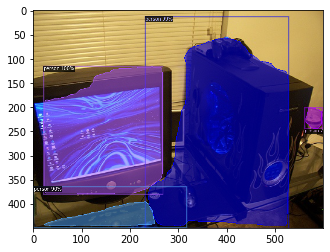

In [11]:
image = (image*255).type(torch.uint8)
out = rpn(image)[0]['instances']
idx = [i for i in range(len(out.pred_masks)) if keep(i, out.pred_masks)]
out = out[idx]
print(len(out))
v = Visualizer(image.cpu().numpy().astype(np.uint8), 
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(out.to("cpu"))
plt.figure()
plt.imshow(v.get_image())

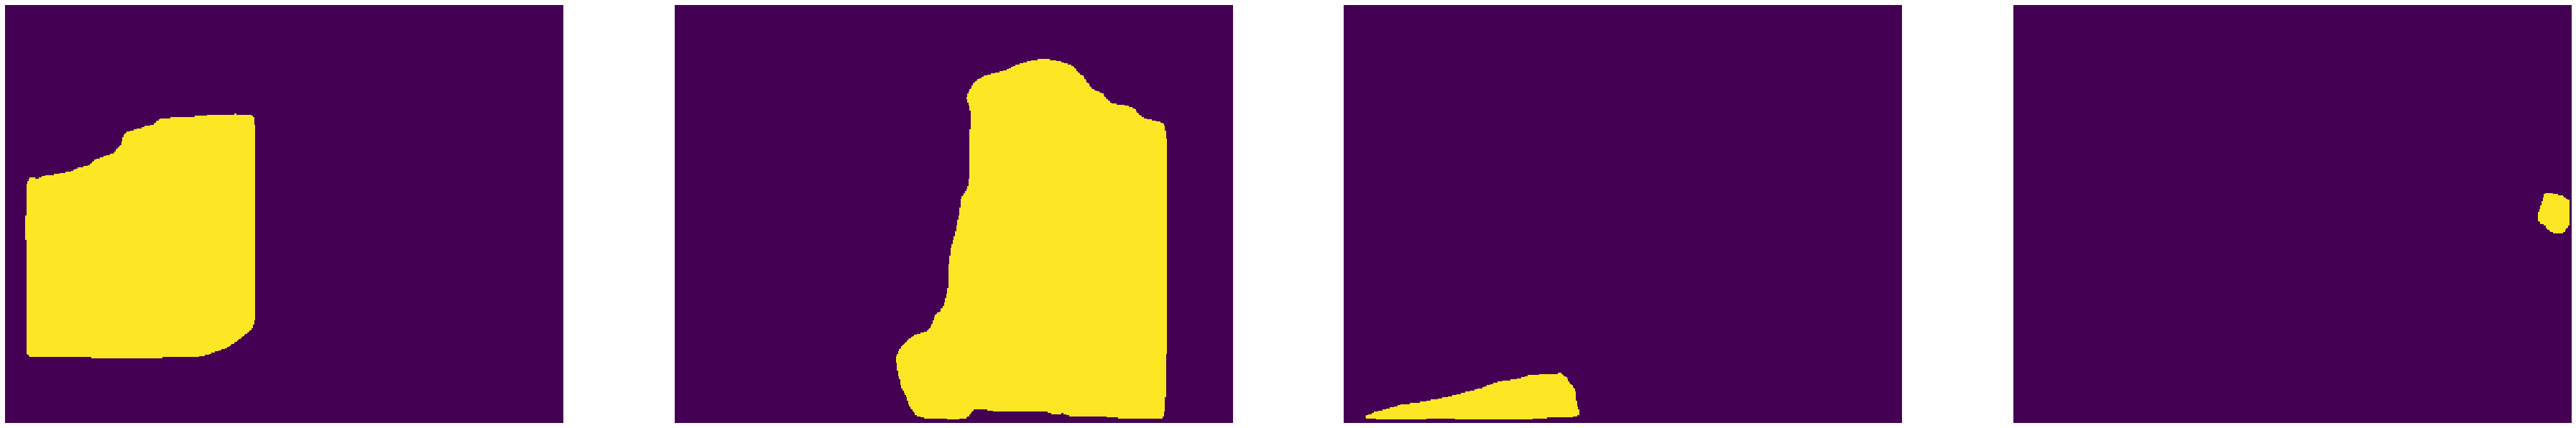

In [12]:
fig, ax = plt.subplots(1, len(out.pred_masks), figsize=(64,64))
for j in range(len(out.pred_masks)):
    ax[j].imshow(out.pred_masks[j].cpu().numpy())
    ax[j].axis('off')

In [13]:
from chainercv.evaluations import eval_instance_segmentation_voc

In [14]:
gt_masks = np.stack([batch['label'] == 1])
gt_labels = np.array([(1,)])

In [15]:
for i in range(len(out.pred_masks)):

    pred_labels = np.array([(1,)])
    pred_masks =  np.stack([out.pred_masks[i].cpu().numpy()])
    pred_scores = np.array([(.9,)])
    print(eval_instance_segmentation_voc([pred_masks], pred_labels, pred_scores, [gt_masks], gt_labels, iou_thresh=0.5))

{'ap': array([nan,  1.]), 'map': 1.0}
{'ap': array([nan,  0.]), 'map': 0.0}
{'ap': array([nan,  0.]), 'map': 0.0}
{'ap': array([nan,  0.]), 'map': 0.0}


In [15]:
# xis_ts, xjs_ts = prepare_object_pairs(out.pred_masks, out.pred_boxes, image.to('cuda'))
# xis = xis_ts.cpu().numpy().transpose(0, 2, 3, 1)

In [14]:
# fig, ax = plt.subplots(1, len(xis), figsize=(64,64))
# for j in range(len(xis)):
#     ax[j].imshow(xis[j])
#     ax[j].axis('off')